# **Task 5 - Transferring attacks (Swin_V2)**
Parameters : 28.4M

**Baseline**

In [2]:
import os
import json
import torch
import torchvision
import numpy as np
from PIL import Image
from tqdm import tqdm
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Load pretrained swin_v2 model
model = torchvision.models.swin_v2_t(weights='IMAGENET1K_V1')
model.eval().cuda()

# Define ImageNet normalization
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

dataset_path = "/content/drive/MyDrive/DL Project 3/TestDataSet/TestDataSet"
test_dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)

# Load official ImageNet class index: maps index → [WNID, label]
with open("/content/drive/MyDrive/DL Project 3/TestDataSet/TestDataSet/imagenet_class_index.json", "r") as f:
    idx_to_info = json.load(f)

# Build WNID → label mapping
wnid_to_label = {v[0]: v[1] for k, v in idx_to_info.items()}

# Load custom label mapping: label → correct ImageNet index
with open(os.path.join(dataset_path, "labels_list.json"), "r") as f:
    label_lines = json.load(f)

label_to_idx = {}
for line in label_lines:
    idx_str, label = line.split(":")
    norm_label = label.strip().replace(" ", "_")
    label_to_idx[norm_label] = int(idx_str.strip())

# Build WNID → correct ImageNet index mapping
wnid_to_correct_idx = {}
for wnid, label in wnid_to_label.items():
    if label in label_to_idx:
        wnid_to_correct_idx[wnid] = label_to_idx[label]

# Rebuild sample list manually with corrected labels
new_samples = []
for folder in sorted(os.listdir(dataset_path)):
    folder_path = os.path.join(dataset_path, folder)
    if not os.path.isdir(folder_path):
        continue
    if folder in wnid_to_correct_idx:
        correct_label = wnid_to_correct_idx[folder]
        for fname in os.listdir(folder_path):
            if fname.lower().endswith(".jpeg"):
                img_path = os.path.join(folder_path, fname)
                new_samples.append((img_path, correct_label))

test_dataset.samples = new_samples

# Prepare DataLoader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluation
def evaluate(model, dataloader):
    top1_correct = 0
    top5_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            _, top5 = outputs.topk(5, dim=1)

            top1_correct += (top5[:, 0] == labels).sum().item()
            top5_correct += sum([labels[i] in top5[i] for i in range(labels.size(0))])
            total += labels.size(0)

    top1_acc = 100 * top1_correct / total
    top5_acc = 100 * top5_correct / total
    return top1_acc, top5_acc

# Run evaluation
top1, top5 = evaluate(model, test_loader)
print(f"\n[Base Line]Top-1 Accuracy: {top1:.2f}%")
print(f"[Base Line]Top-5 Accuracy: {top5:.2f}%")

Downloading: "https://download.pytorch.org/models/swin_v2_t-b137f0e2.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_t-b137f0e2.pth
100%|██████████| 109M/109M [00:00<00:00, 194MB/s] 
100%|██████████| 32/32 [03:41<00:00,  6.91s/it]


[Base Line]Top-1 Accuracy: 78.40%
[Base Line]Top-5 Accuracy: 97.60%


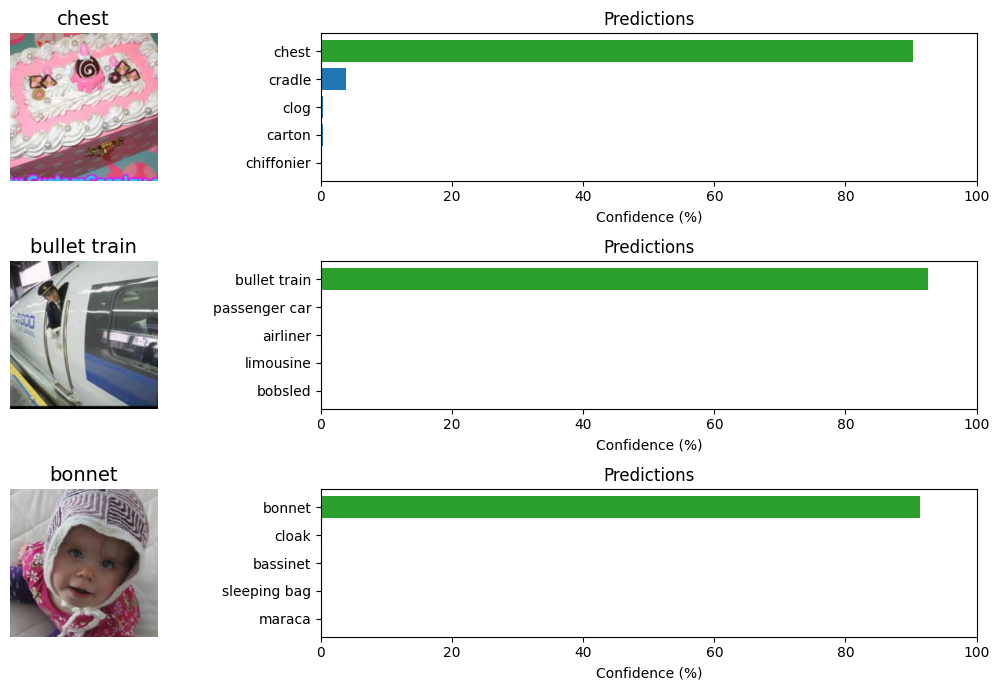

In [3]:
full_label_names = {int(k): v[1].replace('_', ' ')
                    for k, v in idx_to_info.items()}

def unnormalize(img_t):
    img = img_t.cpu().permute(1, 2, 0).numpy()
    img = (img * np.array(std_norms)[None, None, :]) + np.array(mean_norms)[None, None, :]
    return np.clip(img, 0, 1)

import matplotlib.pyplot as plt, numpy as np, random, torch

def plot_three_examples(model, dataset, k=5):
    model_dev = next(model.parameters()).device

    idxs = random.sample(range(len(dataset)), 3)
    imgs  = torch.stack([dataset[i][0] for i in idxs]).to(model_dev)
    gtlbl = torch.tensor([dataset[i][1] for i in idxs])

    with torch.no_grad():
        logits = model(imgs)
        probs  = torch.softmax(logits, dim=-1).cpu()

    fig, axes = plt.subplots(3, 2, figsize=(11, 7),
                             gridspec_kw={'width_ratios': [1, 2]})

    for row in range(3):
        img      = unnormalize(imgs[row])
        gt       = gtlbl[row].item()
        top_vals, top_idx = probs[row].topk(k)
        top_vals = (top_vals.numpy() * 100)
        top_idx  = top_idx.numpy()

        axes[row, 0].imshow(img);     axes[row, 0].axis('off')
        axes[row, 0].set_title(full_label_names.get(gt, str(gt)), fontsize=14)

        colors = ['C2' if top_idx[i] == gt else 'C0' for i in range(k)]
        axes[row, 1].barh(np.arange(k), top_vals, color=colors)
        axes[row, 1].set_yticks(np.arange(k))
        axes[row, 1].set_yticklabels([full_label_names.get(i, str(i)) for i in top_idx])
        axes[row, 1].invert_yaxis();  axes[row, 1].set_xlim(0, 100)
        axes[row, 1].set_xlabel('Confidence (%)'); axes[row, 1].set_title('Predictions')

    plt.tight_layout(); plt.show()

plot_three_examples(model, test_dataset, k=5)

**FGSM**

In [3]:
import torch
import torch.nn.functional as F
from torchvision.utils import save_image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

def fgsm_attack(image, label, model, epsilon=0.02):
    image.requires_grad = True
    output = model(image)
    loss = F.cross_entropy(output, label)
    model.zero_grad()
    loss.backward()
    grad_sign = image.grad.data.sign()
    adv_image = image + epsilon * grad_sign
    return adv_image

adv_dir = "/content/drive/MyDrive/DL Project 3/Adversarial Test Set 1"
os.makedirs(adv_dir, exist_ok=True)

adv_samples = []
original_labels = []
adv_labels = []

model.eval().cuda()
for idx, (images, labels) in enumerate(tqdm(test_loader)):
    images, labels = images.cuda(), labels.cuda()
    adv_images = fgsm_attack(images, labels, model)

    for i in range(images.size(0)):
        img = adv_images[i]
        lbl = labels[i].item()
        output = model(img.unsqueeze(0))
        pred = output.argmax(1).item()
        adv_samples.append(img.cpu())
        original_labels.append(lbl)
        adv_labels.append(pred)

        unnorm = img * torch.tensor(std_norms, device=img.device).view(3, 1, 1) + torch.tensor(mean_norms, device=img.device).view(3, 1, 1)
        save_image(unnorm, os.path.join(adv_dir, f"{idx}_{i}_adv.png"))

from torch.utils.data import TensorDataset, DataLoader

adv_tensor = torch.stack(adv_samples)
adv_targets = torch.tensor(original_labels)
adv_dataset = TensorDataset(adv_tensor, adv_targets)
adv_loader = DataLoader(adv_dataset, batch_size=16)

top1, top5 = evaluate(model, adv_loader)
print(f"\n[FGSM] Top-1 Accuracy: {top1:.2f}%")
print(f"[FGSM] Top-5 Accuracy: {top5:.2f}%")

100%|██████████| 32/32 [00:01<00:00, 22.09it/s]


[FGSM] Top-1 Accuracy: 28.00%
[FGSM] Top-5 Accuracy: 48.80%


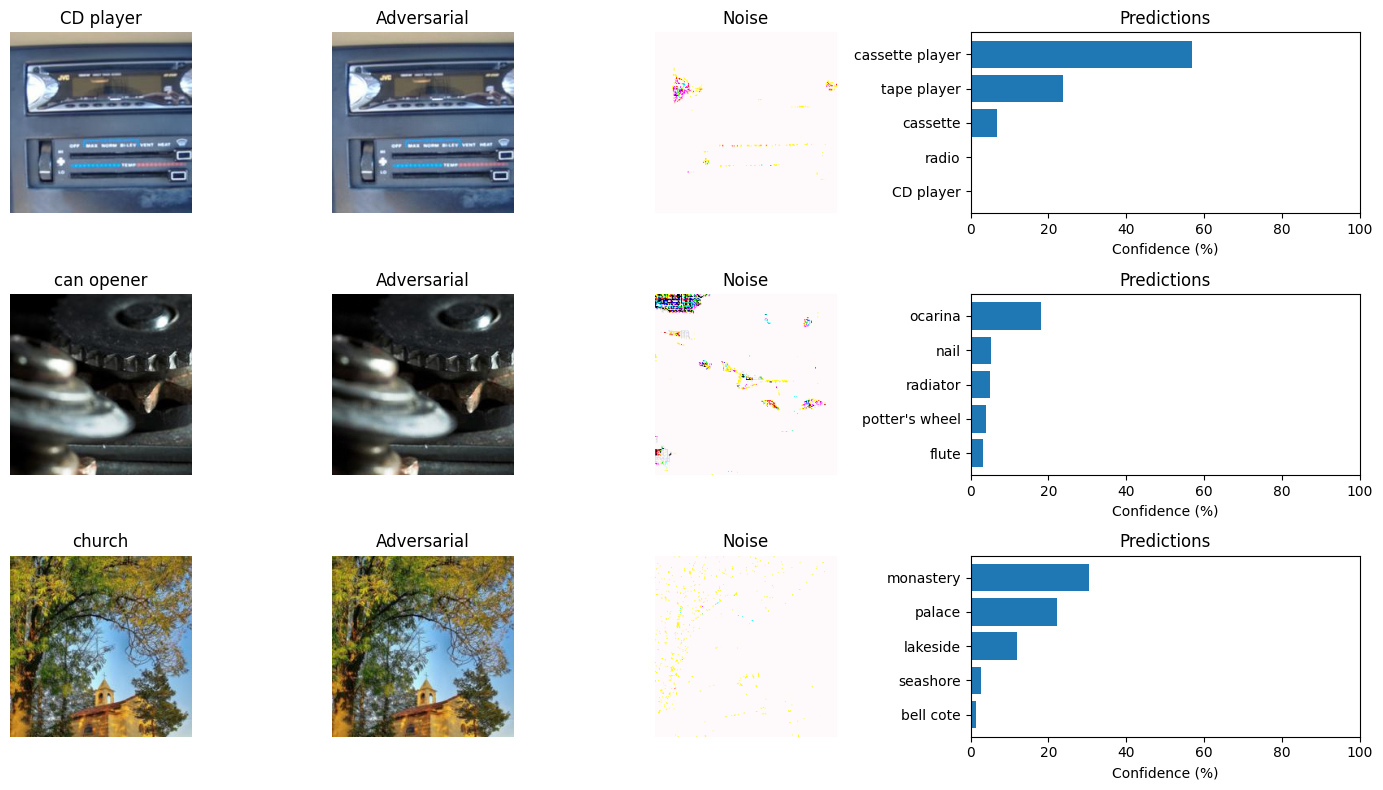

In [4]:
import torch, numpy as np, matplotlib.pyplot as plt, random

def plot_three_fgsm_examples(model,
                             dataset,
                             epsilon   = 0.02,
                             k         = 5,
                             idx_list  = None):

    model_dev = next(model.parameters()).device
    model.eval()

    if idx_list is None:
        idx_list = random.sample(range(len(dataset)), 3)

    imgs, gtlbls, adv_imgs, probs_list = [], [], [], []

    for idx in idx_list:
        img_t, gt_lbl = dataset[idx]
        img_t  = img_t.unsqueeze(0).to(model_dev)
        gt_lbl = torch.tensor([gt_lbl]).to(model_dev)

        adv_t = fgsm_attack(img_t.clone(), gt_lbl, model, epsilon)

        with torch.no_grad():
            adv_prob = torch.softmax(model(adv_t), dim=-1)[0].cpu()

        imgs.append(img_t[0].detach())
        adv_imgs.append(adv_t[0].detach())
        gtlbls.append(gt_lbl.item())
        probs_list.append(adv_prob)

    fig, axes = plt.subplots(3, 4, figsize=(14, 8),
                             gridspec_kw={'width_ratios': [1, 1, 1, 2]})

    for row in range(3):
        clean_disp = unnormalize(imgs[row])
        adv_disp   = unnormalize(adv_imgs[row])
        noise_disp = np.abs(adv_disp - clean_disp)
        if noise_disp.max() > 0:
            noise_disp /= noise_disp.max()

        gt = gtlbls[row]
        top_vals, top_idx = probs_list[row].topk(k)
        top_vals = (top_vals.numpy() * 100)
        top_idx  = top_idx.numpy()

        for col, im, ttl in zip(range(3),
                                [clean_disp, adv_disp, noise_disp],
                                [full_label_names.get(gt, str(gt)),
                                 'Adversarial',
                                 'Noise']):
            ax = axes[row, col]
            ax.imshow(im); ax.axis('off'); ax.set_title(ttl, fontsize=12)

        ax = axes[row, 3]
        colors = ['C2' if top_idx[i] == gt else 'C0' for i in range(k)]
        ax.barh(np.arange(k), top_vals, color=colors)
        ax.set_yticks(np.arange(k))
        ax.set_yticklabels([full_label_names.get(i, str(i)) for i in top_idx])
        ax.invert_yaxis()
        ax.set_xlim(0, 100)
        ax.set_xlabel('Confidence (%)')
        ax.set_title('Predictions', fontsize=12)

    plt.tight_layout()
    plt.show()

plot_three_fgsm_examples(model, test_dataset, epsilon=0.02, k=5)


**I-FGSM**

In [5]:
def ifgsm_attack(image, label, model, eps=0.02, alpha=0.005, steps=60):
    orig = image.detach()
    adv  = orig.clone().detach().requires_grad_(True)
    for _ in range(steps):
        output = model(adv)
        loss   = F.cross_entropy(output, label)
        model.zero_grad()
        adv.grad = None
        loss.backward()
        adv.data += alpha * adv.grad.sign()
        perturb  = torch.clamp(adv - orig, min=-eps, max=eps)
        adv.data = orig + perturb

    max_delta = (adv - orig).abs().max().item()
    return adv.detach()


adv_dir = "/content/drive/MyDrive/DL Project 3/Adversarial Test Set 1 (I-FGSM)"
os.makedirs(adv_dir, exist_ok=True)

adv_samples, original_labels, adv_labels = [], [], []

model.eval().cuda()
for idx, (images, labels) in enumerate(tqdm(test_loader)):
    images, labels = images.cuda(), labels.cuda()
    adv_images = ifgsm_attack(images, labels, model)

    for i in range(images.size(0)):
        img = adv_images[i]
        lbl = labels[i].item()
        pred = model(img.unsqueeze(0)).argmax(1).item()

        adv_samples.append(img.cpu())
        original_labels.append(lbl)
        adv_labels.append(pred)

        unnorm = img * torch.tensor(std_norms, device=img.device).view(3,1,1) \
                   + torch.tensor(mean_norms, device=img.device).view(3,1,1)
        save_image(unnorm, os.path.join(adv_dir, f"{idx}_{i}_ifgsm.png"))

adv_tensor = torch.stack(adv_samples)
adv_dataset = TensorDataset(adv_tensor, torch.tensor(original_labels))
adv_loader  = DataLoader(adv_dataset, batch_size=16)

top1, top5 = evaluate(model, adv_loader)
print(f"\n[I-FGSM] Top-1 Accuracy: {top1:.2f}%")
print(f"[I-FGSM] Top-5 Accuracy: {top5:.2f}%")

100%|██████████| 32/32 [00:01<00:00, 21.61it/s]


[I-FGSM] Top-1 Accuracy: 0.00%
[I-FGSM] Top-5 Accuracy: 0.40%


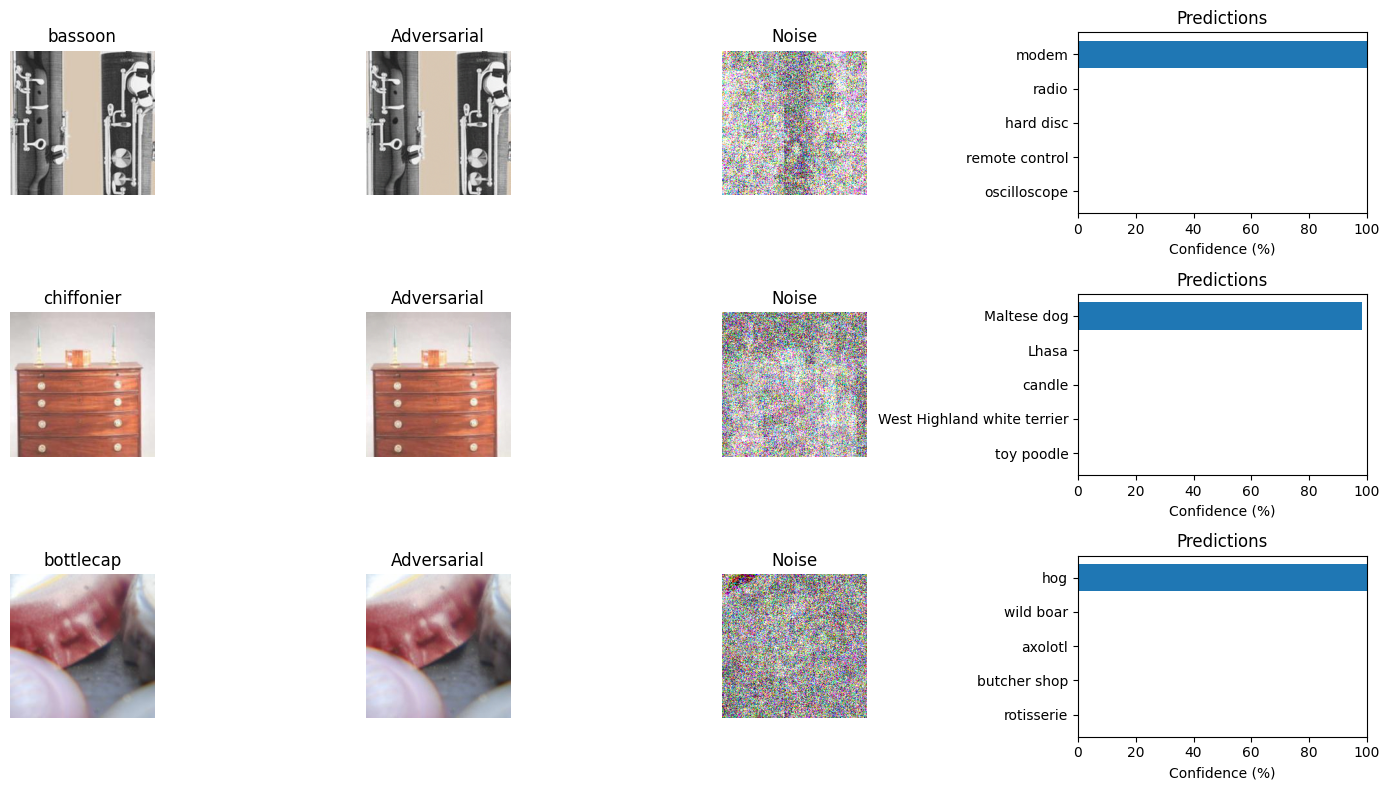

In [6]:
import torch, numpy as np, matplotlib.pyplot as plt, random

def plot_three_ifgsm_examples(model,
                              dataset,
                              eps        = 0.02,
                              alpha      = 0.005,
                              steps      = 60,
                              k          = 5,
                              idx_list   = None):

    model_dev = next(model.parameters()).device
    model.eval()

    if idx_list is None:
        idx_list = random.sample(range(len(dataset)), 3)

    imgs, adv_imgs, gtlbls, probs_list = [], [], [], []

    for idx in idx_list:
        img_t, gt_lbl = dataset[idx]
        img_t  = img_t.unsqueeze(0).to(model_dev)
        gt_lbl = torch.tensor([gt_lbl]).to(model_dev)

        adv_t = ifgsm_attack(img_t.clone(), gt_lbl, model,
                             eps=eps, alpha=alpha, steps=steps)

        with torch.no_grad():
            adv_prob = torch.softmax(model(adv_t), dim=-1)[0].cpu()

        imgs.append(img_t[0].detach())
        adv_imgs.append(adv_t[0].detach())
        gtlbls.append(gt_lbl.item())
        probs_list.append(adv_prob)

    fig, axes = plt.subplots(3, 4, figsize=(14, 8),
                             gridspec_kw={'width_ratios': [1, 1, 1, 2]})

    for row in range(3):
        clean_disp = unnormalize(imgs[row])
        adv_disp   = unnormalize(adv_imgs[row])
        noise_disp = np.abs(adv_disp - clean_disp)
        if noise_disp.max() > 0:
            noise_disp /= noise_disp.max()

        gt = gtlbls[row]
        top_vals, top_idx = probs_list[row].topk(k)
        top_vals = (top_vals.numpy() * 100)
        top_idx  = top_idx.numpy()


        for col, im, ttl in zip(range(3),
                                [clean_disp, adv_disp, noise_disp],
                                [full_label_names.get(gt, str(gt)),
                                 'Adversarial',
                                 'Noise']):
            ax = axes[row, col]
            ax.imshow(im)
            ax.axis('off')
            ax.set_title(ttl, fontsize=12)

        ax = axes[row, 3]
        colors = ['C2' if top_idx[i] == gt else 'C0' for i in range(k)]
        ax.barh(np.arange(k), top_vals, color=colors)
        ax.set_yticks(np.arange(k))
        ax.set_yticklabels([full_label_names.get(i, str(i)) for i in top_idx])
        ax.invert_yaxis()
        ax.set_xlim(0, 100)
        ax.set_xlabel('Confidence (%)')
        ax.set_title('Predictions', fontsize=12)

    plt.tight_layout()
    plt.show()

plot_three_ifgsm_examples(model, test_dataset)

**MI-FGSM**

In [7]:
def mifgsm_attack(image, label, model, eps=0.02, alpha=0.005, steps=60, mu=0.5):
    orig = image.detach()
    adv  = orig.clone().detach().requires_grad_(True)
    momentum = torch.zeros_like(adv)

    for _ in range(steps):
        output = model(adv)
        loss   = F.cross_entropy(output, label)
        model.zero_grad()
        adv.grad = None
        loss.backward()

        grad = adv.grad / adv.grad.abs().mean(dim=(1,2,3), keepdim=True)
        momentum = mu * momentum + grad
        adv.data += alpha * momentum.sign()

        perturb  = torch.clamp(adv - orig, min=-eps, max=eps)
        adv.data = orig + perturb

    return adv.detach()

adv_dir = "/content/drive/MyDrive/DL Project 3/Adversarial Test Set 1 (MI-FGSM)"
os.makedirs(adv_dir, exist_ok=True)

adv_samples, original_labels, adv_labels = [], [], []

model.eval().cuda()
for idx, (images, labels) in enumerate(tqdm(test_loader)):
    images, labels = images.cuda(), labels.cuda()
    adv_images = mifgsm_attack(images, labels, model)

    for i in range(images.size(0)):
        img = adv_images[i]
        lbl = labels[i].item()
        pred = model(img.unsqueeze(0)).argmax(1).item()

        adv_samples.append(img.cpu())
        original_labels.append(lbl)
        adv_labels.append(pred)

        unnorm = img * torch.tensor(std_norms, device=img.device).view(3,1,1) \
                   + torch.tensor(mean_norms, device=img.device).view(3,1,1)
        save_image(unnorm, os.path.join(adv_dir, f"{idx}_{i}_mifgsm.png"))

adv_tensor = torch.stack(adv_samples)
adv_dataset = TensorDataset(adv_tensor, torch.tensor(original_labels))
adv_loader  = DataLoader(adv_dataset, batch_size=16)

top1, top5 = evaluate(model, adv_loader)
print(f"\n[MI-FGSM] Top-1 Accuracy: {top1:.2f}%")
print(f"[MI-FGSM] Top-5 Accuracy: {top5:.2f}%")

100%|██████████| 32/32 [00:01<00:00, 21.53it/s]


[MI-FGSM] Top-1 Accuracy: 0.00%
[MI-FGSM] Top-5 Accuracy: 0.20%


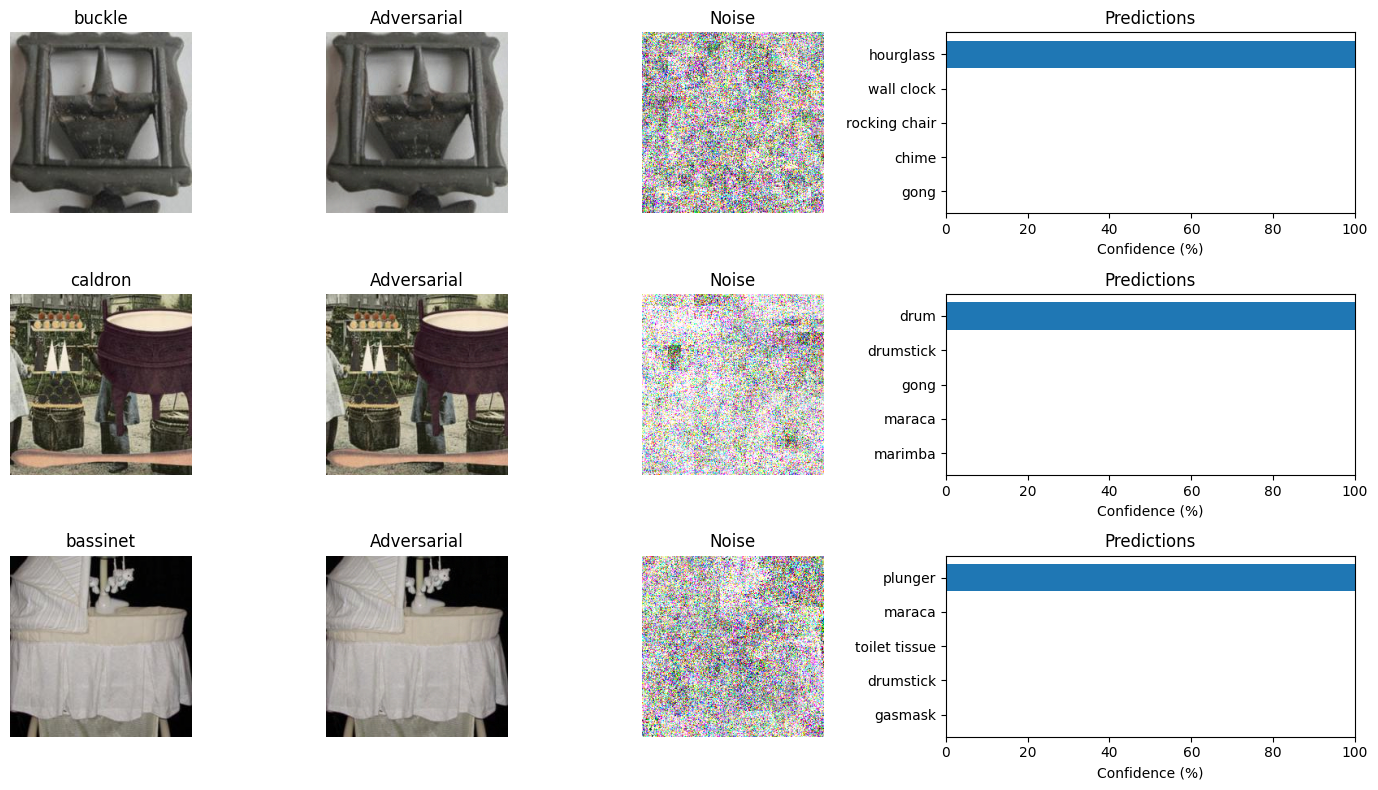

In [8]:
def plot_three_mifgsm_examples(model,
                               dataset,
                               eps      = 0.02,
                               alpha    = 0.005,
                               steps    = 60,
                               mu       = 0.5,
                               k        = 5,
                               idx_list = None):

    model_dev = next(model.parameters()).device
    model.eval()

    if idx_list is None:
        idx_list = random.sample(range(len(dataset)), 3)

    imgs, adv_imgs, gtlbls, probs_list = [], [], [], []

    for idx in idx_list:
        img_t, gt_lbl = dataset[idx]
        img_t  = img_t.unsqueeze(0).to(model_dev)
        gt_lbl = torch.tensor([gt_lbl]).to(model_dev)

        adv_t = mifgsm_attack(img_t.clone(), gt_lbl, model,
                              eps=eps, alpha=alpha, steps=steps, mu=mu)

        with torch.no_grad():
            adv_prob = torch.softmax(model(adv_t), dim=-1)[0].cpu()

        imgs.append(img_t[0].detach())
        adv_imgs.append(adv_t[0].detach())
        gtlbls.append(gt_lbl.item())
        probs_list.append(adv_prob)

    fig, axes = plt.subplots(3, 4, figsize=(14, 8),
                             gridspec_kw={'width_ratios': [1, 1, 1, 2]})

    for row in range(3):
        clean_disp = unnormalize(imgs[row])
        adv_disp   = unnormalize(adv_imgs[row])
        noise_disp = np.abs(adv_disp - clean_disp)
        if noise_disp.max() > 0:
            noise_disp /= noise_disp.max()

        gt = gtlbls[row]
        top_vals, top_idx = probs_list[row].topk(k)
        top_vals = (top_vals.numpy() * 100)
        top_idx  = top_idx.numpy()

        for col, im, ttl in zip(range(3),
                                [clean_disp, adv_disp, noise_disp],
                                [full_label_names.get(gt, str(gt)),
                                 'Adversarial',
                                 'Noise']):
            ax = axes[row, col]
            ax.imshow(im); ax.axis('off'); ax.set_title(ttl, fontsize=12)

        ax = axes[row, 3]
        colors = ['C2' if top_idx[i] == gt else 'C0' for i in range(k)]
        ax.barh(np.arange(k), top_vals, color=colors)
        ax.set_yticks(np.arange(k))
        ax.set_yticklabels([full_label_names.get(i, str(i)) for i in top_idx])
        ax.invert_yaxis()
        ax.set_xlim(0, 100)
        ax.set_xlabel('Confidence (%)')
        ax.set_title('Predictions', fontsize=12)

    plt.tight_layout()
    plt.show()


plot_three_mifgsm_examples(model, test_dataset)

**PGD**

In [4]:
def pgd_attack(image, label, model,
               eps=0.02, alpha=0.005, steps=60,
               random_start=True, restarts=10):

    orig   = image.detach()
    device = image.device
    best_adv  = orig.clone()
    best_loss = torch.full((image.size(0),), -1e9, device=device)

    for _ in range(restarts):
        if random_start:
            adv = orig + torch.empty_like(orig).uniform_(-eps, eps)
        else:
            adv = orig.clone()
        adv = adv.detach().requires_grad_(True)

        for _ in range(steps):
            logits = model(adv)
            loss   = F.cross_entropy(logits, label)
            model.zero_grad()
            adv.grad = None
            loss.backward()

            adv.data += alpha * adv.grad.sign()
            perturb  = torch.clamp(adv - orig, min=-eps, max=eps)
            adv.data = orig + perturb

        with torch.no_grad():
            final_logits = model(adv)
            final_loss   = F.cross_entropy(final_logits, label, reduction='none')
            better       = final_loss > best_loss
            best_loss[better] = final_loss[better]
            best_adv [better] = adv[better]

    return best_adv.detach()

adv_dir = "/content/drive/MyDrive/DL Project 3/Adversarial Test Set 1 (PGD)"
os.makedirs(adv_dir, exist_ok=True)

adv_samples, orig_labels = [], []

model.eval().cuda()
for idx, (images, labels) in enumerate(tqdm(test_loader)):
    images, labels = images.cuda(), labels.cuda()
    adv_images = pgd_attack(images, labels, model,
                            eps=0.02, alpha=0.005,
                            steps=60, random_start=True,
                            restarts=10)

    adv_samples.extend(adv_images.cpu())
    orig_labels.extend(labels.cpu())

    for i in range(images.size(0)):
        unnorm = adv_images[i] * torch.tensor(std_norms, device=adv_images.device).view(3,1,1) \
                          + torch.tensor(mean_norms, device=adv_images.device).view(3,1,1)
        save_image(unnorm.cpu(), os.path.join(adv_dir, f"{idx}_{i}_pgd.png"))

adv_tensor = torch.stack(adv_samples)
adv_dataset = TensorDataset(adv_tensor, torch.tensor(orig_labels))
adv_loader  = DataLoader(adv_dataset, batch_size=16)

top1, top5 = evaluate(model, adv_loader)
print(f"\n[PGD] Top-1 Accuracy: {top1:.2f}%")
print(f"[PGD] Top-5 Accuracy: {top5:.2f}%")

100%|██████████| 32/32 [00:01<00:00, 21.92it/s]


[PGD] Top-1 Accuracy: 0.00%
[PGD] Top-5 Accuracy: 0.00%


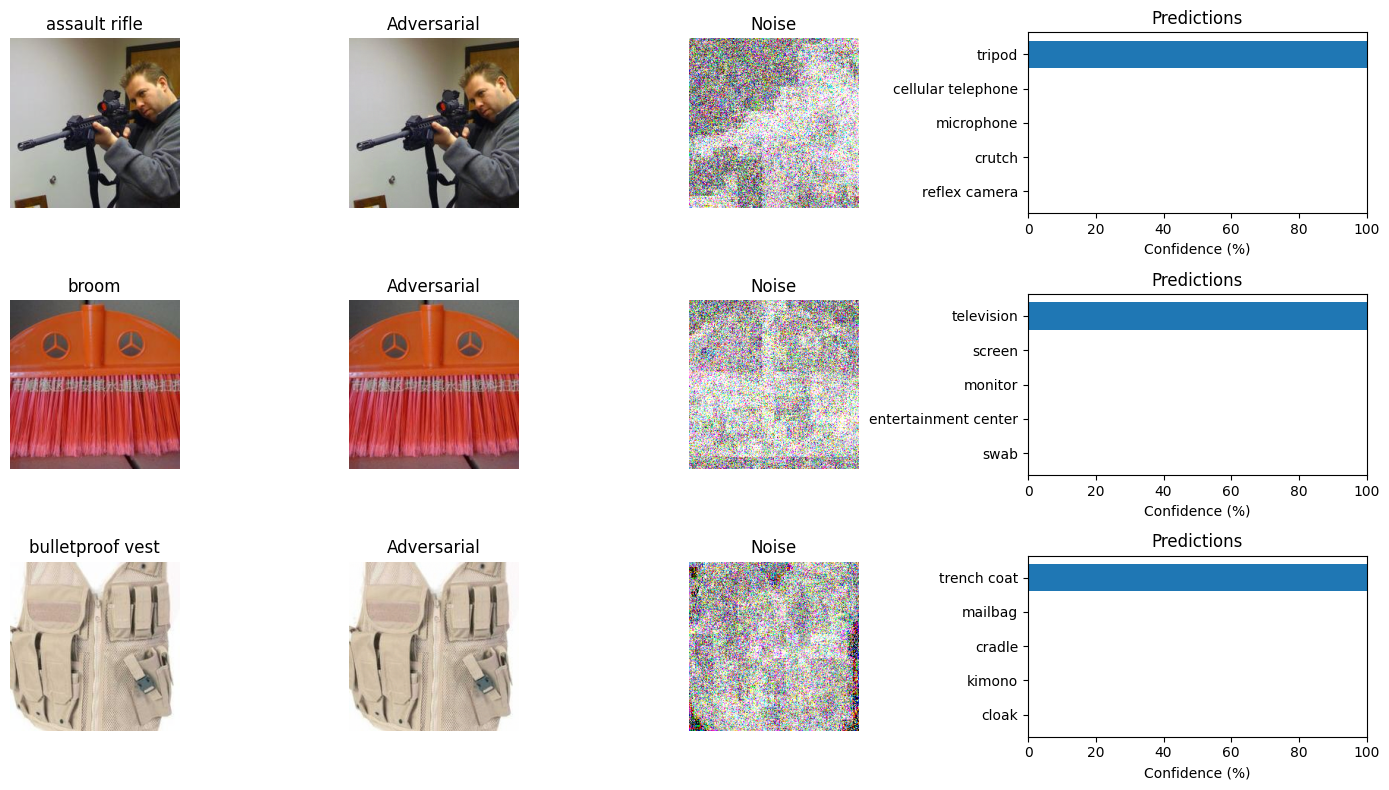

In [5]:
import torch, numpy as np, matplotlib.pyplot as plt, random

def plot_three_pgd_examples(model,
                            dataset,
                            eps        = 0.02,
                            alpha      = 0.005,
                            steps      = 60,
                            restarts   = 10,
                            random_start = True,
                            k          = 5,
                            idx_list   = None):

    model_dev = next(model.parameters()).device
    model.eval()

    if idx_list is None:
        idx_list = random.sample(range(len(dataset)), 3)

    clean_t, adv_t, gtlbls, probs_list = [], [], [], []

    for idx in idx_list:
        img, lbl = dataset[idx]
        img_t  = img.unsqueeze(0).to(model_dev)
        lbl_t  = torch.tensor([lbl]).to(model_dev)

        adv_img = pgd_attack(img_t.clone(), lbl_t, model,
                             eps=eps, alpha=alpha, steps=steps,
                             random_start=random_start, restarts=restarts)

        with torch.no_grad():
            probs = torch.softmax(model(adv_img), dim=-1)[0].cpu()

        clean_t.append(img_t[0].detach())
        adv_t.append(adv_img[0].detach())
        gtlbls.append(lbl)
        probs_list.append(probs)

    fig, axes = plt.subplots(3, 4, figsize=(14, 8),
                             gridspec_kw={'width_ratios': [1, 1, 1, 2]})

    for row in range(3):
        clean_disp = unnormalize(clean_t[row])
        adv_disp   = unnormalize(adv_t[row])
        noise_disp = np.abs(adv_disp - clean_disp)
        if noise_disp.max() > 0:
            noise_disp /= noise_disp.max()

        gt = gtlbls[row]
        top_vals, top_idx = probs_list[row].topk(k)
        top_vals = (top_vals.numpy() * 100)
        top_idx  = top_idx.numpy()


        for col, im, ttl in zip(range(3),
                                [clean_disp, adv_disp, noise_disp],
                                [full_label_names.get(gt, str(gt)),
                                 'Adversarial',
                                 'Noise']):
            ax = axes[row, col]
            ax.imshow(im)
            ax.axis('off')
            ax.set_title(ttl, fontsize=12)

        ax = axes[row, 3]
        colors = ['C2' if top_idx[i] == gt else 'C0' for i in range(k)]
        ax.barh(np.arange(k), top_vals, color=colors)
        ax.set_yticks(np.arange(k))
        ax.set_yticklabels([full_label_names.get(i, str(i)) for i in top_idx])
        ax.invert_yaxis()
        ax.set_xlim(0, 100)
        ax.set_xlabel('Confidence (%)')
        ax.set_title('Predictions', fontsize=12)

    plt.tight_layout()
    plt.show()

plot_three_pgd_examples(model, test_dataset, eps=0.02, alpha=0.005,
                         steps=60, restarts=10)


**Patch PGD with Momentum**

In [6]:
def patch_pgd_momentum(image, label, model,
                       eps=0.5, alpha=0.08, steps=60,
                       mu=0.5, restarts=10, patch_size=32):

    B, _, H, W = image.size()
    device = image.device

    mask = torch.zeros_like(image)
    coords = []
    for i in range(B):
        t = torch.randint(0, H - patch_size + 1, ()).item()
        l = torch.randint(0, W - patch_size + 1, ()).item()
        mask[i, :, t:t+patch_size, l:l+patch_size] = 1
        coords.append((t, l))

    orig = image.detach()
    best_adv = orig.clone()
    best_loss = torch.full((B,), -1e9, device=device)

    for _ in range(restarts):
        adv = (orig + (torch.empty_like(orig).uniform_(-eps, eps) * mask)).detach()
        g   = torch.zeros_like(adv)

        for _ in range(steps):
            look = (adv + alpha * mu * g).detach().requires_grad_(True)
            logits = model(look)
            loss   = F.cross_entropy(logits, label, reduction='none')  # per-sample
            model.zero_grad()
            look.grad = None
            loss.sum().backward()

            grad = look.grad / (look.grad.abs().mean(dim=(1,2,3), keepdim=True) + 1e-8)
            grad = grad * mask
            g    = mu * g + grad
            adv  = adv + alpha * g.sign() * mask

            perturb = torch.clamp(adv - orig, min=-eps, max=eps) * mask
            adv     = orig + perturb

        with torch.no_grad():
            final_logits = model(adv)
            final_loss   = F.cross_entropy(final_logits, label, reduction='none')
            better = final_loss > best_loss
            best_loss[better] = final_loss[better]
            best_adv [better] = adv[better]

    return best_adv.detach(), coords

adv_dir = "/content/drive/MyDrive/DL Project 3/Adversarial Test Set 3 (Patch-PGD)"
os.makedirs(adv_dir, exist_ok=True)

adv_samples, orig_samples, coords_list = [], [], []
orig_labels, adv_labels = [], []

model.eval().cuda()
for idx, (images, labels) in enumerate(tqdm(test_loader)):
    images, labels = images.cuda(), labels.cuda()

    adv_images, coords = patch_pgd_momentum(images, labels, model)
    logits = model(adv_images)
    preds  = logits.argmax(1)

    adv_samples.extend(adv_images.cpu())
    orig_samples.extend(images.cpu())
    coords_list.extend(coords)
    orig_labels.extend(labels.cpu())
    adv_labels.extend(preds.cpu())

    for i in range(images.size(0)):
        save_image(adv_images[i].cpu(),
                   os.path.join(adv_dir, f"{idx}_{i}_patchpgd.png"))

adv_tensor = torch.stack(adv_samples)
orig_tensor = torch.stack(orig_samples)
adv_dataset = TensorDataset(adv_tensor, torch.tensor(orig_labels))
adv_loader  = DataLoader(adv_dataset, batch_size=16)

top1, top5 = evaluate(model, adv_loader)
print(f"\n[Patch-PGD] Top-1 Accuracy: {top1:.2f}%")
print(f"[Patch-PGD] Top-5 Accuracy: {top5:.2f}%")

100%|██████████| 32/32 [00:01<00:00, 21.74it/s]


[Patch-PGD] Top-1 Accuracy: 24.20%
[Patch-PGD] Top-5 Accuracy: 72.40%


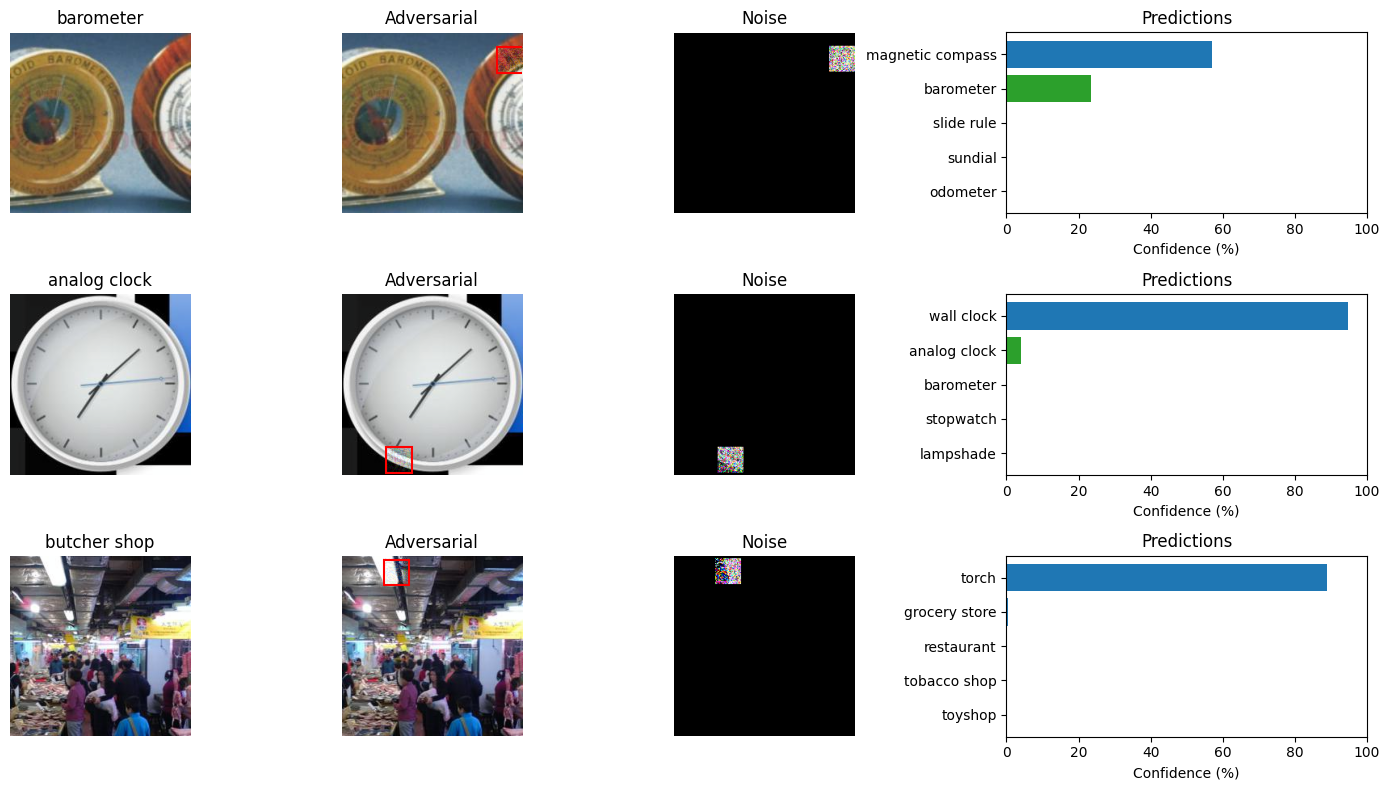

In [7]:
import torch, numpy as np, matplotlib.pyplot as plt, random
from matplotlib.patches import Rectangle

def plot_three_patchpgd_examples(model,
                                 dataset,
                                 eps        = 0.5,
                                 alpha      = 0.08,
                                 steps      = 60,
                                 mu         = 0.5,
                                 restarts   = 10,
                                 patch_size = 32,
                                 k          = 5,
                                 idx_list   = None):

    model_dev = next(model.parameters()).device
    model.eval()

    if idx_list is None:
        idx_list = random.sample(range(len(dataset)), 3)

    clean_t, adv_t, coords_list, gtlbls, probs_list = [], [], [], [], []

    for idx in idx_list:
        img, lbl = dataset[idx]
        img_t  = img.unsqueeze(0).to(model_dev)
        lbl_t  = torch.tensor([lbl]).to(model_dev)

        adv_img, coords = patch_pgd_momentum(img_t.clone(), lbl_t, model,
                                             eps=eps, alpha=alpha, steps=steps,
                                             mu=mu, restarts=restarts,
                                             patch_size=patch_size)

        with torch.no_grad():
            probs = torch.softmax(model(adv_img), dim=-1)[0].cpu()

        clean_t.append(img_t[0].detach())
        adv_t.append(adv_img[0].detach())
        coords_list.append(coords[0])
        gtlbls.append(lbl)
        probs_list.append(probs)

    fig, axes = plt.subplots(3, 4, figsize=(14, 8),
                             gridspec_kw={'width_ratios': [1, 1, 1, 2]})

    for row in range(3):
        clean_disp = unnormalize(clean_t[row])
        adv_disp   = unnormalize(adv_t[row])
        noise_disp = np.abs(adv_disp - clean_disp)
        if noise_disp.max() > 0:
            noise_disp /= noise_disp.max()

        gt = gtlbls[row]
        top_vals, top_idx = probs_list[row].topk(k)
        top_vals = (top_vals.numpy() * 100)
        top_idx  = top_idx.numpy()

        titles = [full_label_names.get(gt, str(gt)),
                  'Adversarial', 'Noise']
        for col, im, ttl in zip(range(3),
                                [clean_disp, adv_disp, noise_disp],
                                titles):
            ax = axes[row, col]
            ax.imshow(im)
            ax.axis('off')
            ax.set_title(ttl, fontsize=12)

        t, l = coords_list[row]
        patch = Rectangle((l, t), patch_size, patch_size,
                          linewidth=1.5, edgecolor='red', facecolor='none')
        axes[row, 1].add_patch(patch)
        ax = axes[row, 3]
        colors = ['C2' if top_idx[i] == gt else 'C0' for i in range(k)]
        ax.barh(np.arange(k), top_vals, color=colors)
        ax.set_yticks(np.arange(k))
        ax.set_yticklabels([full_label_names.get(i, str(i)) for i in top_idx])
        ax.invert_yaxis()
        ax.set_xlim(0, 100)
        ax.set_xlabel('Confidence (%)')
        ax.set_title('Predictions', fontsize=12)

    plt.tight_layout()
    plt.show()

plot_three_patchpgd_examples(model, test_dataset)